En esta notebook voy a crear mi primer modelo de ML no supervisado. A partir de un csv de vinos intentaremos crear clusters de las diferentes marcas de vino (usaremos el algoritmo de k-means clustering)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('C:/Users/PuigmalS/NoSupervisado/wine.csv')

In [3]:
df.head()

,class_label,class_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1,Barolo,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,Barolo,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,Barolo,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,Barolo,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,Barolo,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Bien, está claro que debemos eliminar las columnas de class_label y class_name ya que contienen la información que queremos encontrar con nuestro modelo. Antes de eliminarlas veamos cuantos elementos tenemos de cada tipo de vino. Así podremos saber si nuestro modelo está o no bien planteado:

In [4]:
df.class_name.value_counts()

Grignolino    71
Barolo        59
Barbera       48
Name: class_name, dtype: int64

Ya podemos borrar las columnas!

In [5]:
samples = df.drop(['class_name', 'class_label'], axis=1).values

En este punto tenemos que decidir con cuantos clusters trabajaremos. Sabemos de antemano que son 3, pero debemos descubrirlo con nuestro modelo (de lo contrario estaríamos haciendo trampas)
Vamos a calcular la inercia con diferentes números de clústers:

C:\Users\PuigmalS\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


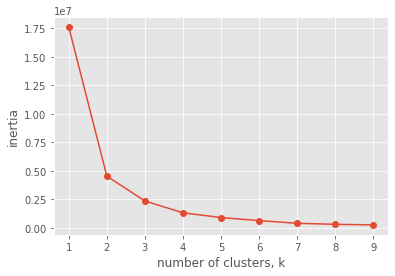

In [6]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(samples)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Nuestro objetivo es minimizar la inercia (que es una medida de proximidad entre cada muestra y el centroide de su cluster), pero tampoco podemos trabajar con demasiados clústers. La literatura inglesa habla de encontrar el "elbow" en nuestro gráfico. Esto es, buscar el punto en el que la pendiente de la inercia empiece a ser menos pronunciada. Vemos que en k=3 y k=4 se cumple lo anterior. 

Ahora ya podemos hacer un k=3 (luego probaremos con 4 a ver qué sale) y un predict:

In [7]:
model = KMeans(n_clusters=3)
labels = model.fit_predict(samples)

Ahora ya podemos hacer un cross tab de nuestro modelo y un nuevo dataFrame de las columnas eliminadas:

In [8]:
varieties= df['class_name']
df = pd.DataFrame({'labels': labels, 'varieties': varieties}) 

df.head()

,labels,varieties
0,2,Barolo
1,2,Barolo
2,2,Barolo
3,2,Barolo
4,0,Barolo


Sólo viendo las 5 primeras columnas la cosa ya tiene mala pinta... A ver con el crosstab:

In [9]:
cross_tab = pd.crosstab(df['labels'], df['varieties'])
print(cross_tab)

varieties  Barbera  Barolo  Grignolino
labels                                
0               29      13          20
1               19       0          50
2                0      46           1


Los resultados son muy malos. A ver si estandarizando los datos se arregla algo:

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3)
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(samples)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3))])

In [11]:
labels_standarized = pipeline.predict(samples)

In [12]:
df2 = pd.DataFrame({'labels': labels_standarized, 'varieties': varieties}) 
cross_tab = pd.crosstab(df2['labels'], df2['varieties'])

print(cross_tab)

varieties  Barbera  Barolo  Grignolino
labels                                
0               48       0           3
1                0      59           3
2                0       0          65


Los resultados son muy buenos! No del 100% de aciertos pero no están nada mal.
Voy a intentar reducir la dimensión de los datos con la técnica de Principal Component Analysis a ver si obtenemos resultados también buenos:

In [13]:
from sklearn.decomposition import PCA

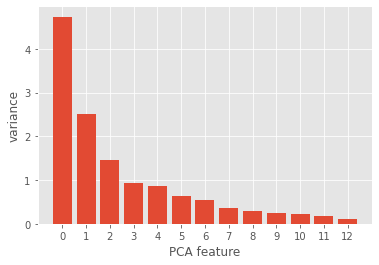

In [14]:
df = pd.read_csv('C:/Users/PuigmalS/NoSupervisado/wine.csv') 
samples = df.drop(['class_name', 'class_label'], axis=1).values 
scaler = StandardScaler()
pca = PCA() 
pipeline = make_pipeline(scaler, pca)
pipeline.fit(samples)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Viendo el gráfico anterior, supongamos que tenemos 3 variables informativas y el resto son ruidosas. Reduzcamos ahora la dimensión de nuestro modelo:

In [15]:
scaler = StandardScaler()
pca = PCA(n_components=3)  
pipeline = make_pipeline(scaler, pca)
pipeline.fit(samples)

transformed = pipeline.transform(samples)


In [16]:
print("Mediante PCA hemos pasado de un modelo {} a un modelo {}".format(samples.shape, transformed.shape))

Mediante PCA hemos pasado de un modelo (178, 13) a un modelo (178, 3)


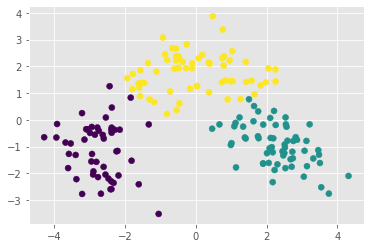

In [17]:
xs = transformed[:,0]
ys = transformed[:,1]

plt.scatter(xs, ys, c=labels_standarized)
plt.show() 

Los clústers se ven muy bien! A ver si podemos dibujar los centroides respectivos:

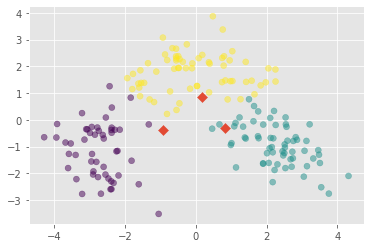

In [18]:
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys, c=labels_standarized, alpha=0.5)
centroids = kmeans.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

plt.scatter(centroids_x ,centroids_y, marker='D',s=50 )
plt.show()